# Field Goals: An Observational Study ⛰️

* Hypothesis: Long range field goals have a greater change of conversion at altitude than sea-level.
* Hypothesis: Icing a kicker prior to an attempty reduces the likelihood of conversion.

In [17]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import mysql.connector
import itertools
import dtale
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
from datetime import datetime as dt
from util.data import clean, get_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing

In [18]:
# load and clean the data
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df['temperature'] = ((df['temperature']-32)*5/9).astype(int) # to celcius
df = df.drop(['fkicker', 'home_team', 'stadium', 'team', 'XP', 'humid'], axis=1)
df.dropna(inplace=True)
df

,good,dist,year,seasons,temperature,age,altitude,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,
2166,1,38,2000,17,22,38,0,10,1,0,0,1,0,1,0.764708,765
2185,1,27,2000,17,22,38,0,10,1,0,0,1,0,1,0.807721,766
4565,1,36,2000,17,26,38,0,13,0,0,1,0,0,5,0.842837,767
8564,1,24,2000,17,16,38,0,16,1,0,0,1,1,1,0.842837,768
8628,1,40,2000,17,16,38,0,16,1,0,0,1,1,1,0.871516,769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862982,1,30,2019,3,18,24,0,0,0,0,0,0,0,1,0.826709,62
865338,1,21,2019,3,18,24,0,11,0,0,0,0,0,2,0.858217,63
868268,1,22,2019,3,6,24,0,7,1,0,0,1,0,1,1.000000,64


There seems to be a slight up-tick for long range kicks (+45 yards), but the sample size is quite small, as indicated by the confidence bands.

## Variable of Interest

We filter for away kicks at altitude because only Denver home games are at altitude, so need to avoid biasing for Broncos kicker.

In [19]:
on = 'iced'
# df = df[(df['away_game']==1) | (df['altitude']==0)] # for altitude study
df[on] = df[on].astype(bool)

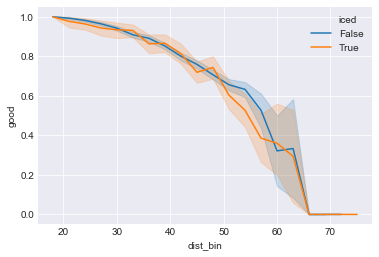

In [20]:
df_ = df.copy()
df_['dist_bin'] = 3*round(df_['dist']/3)
sns.lineplot(x='dist_bin', y='good', hue=on, data=df_)

In [21]:
print(df[on].value_counts())
df

False    16452
True      2351
Name: iced, dtype: int64


,good,dist,year,seasons,temperature,age,altitude,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,
2166,1,38,2000,17,22,38,0,10,1,0,False,1,0,1,0.764708,765
2185,1,27,2000,17,22,38,0,10,1,0,False,1,0,1,0.807721,766
4565,1,36,2000,17,26,38,0,13,0,0,True,0,0,5,0.842837,767
8564,1,24,2000,17,16,38,0,16,1,0,False,1,1,1,0.842837,768
8628,1,40,2000,17,16,38,0,16,1,0,False,1,1,1,0.871516,769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862982,1,30,2019,3,18,24,0,0,0,0,False,0,0,1,0.826709,62
865338,1,21,2019,3,18,24,0,11,0,0,False,0,0,2,0.858217,63
868268,1,22,2019,3,6,24,0,7,1,0,False,1,0,1,1.000000,64


## Matching

### Coarsened Exact Matching

In [22]:
bins = {
    'dist': (df['dist'].min()-1, 40, 50, df['dist'].max()), #short, medium and long
    'year': (df['year'].min()-1, 2005, 2010, 2015, df['year'].max()),
    'seasons': (df['seasons'].min()-1, 5, 10, 15, df['seasons'].max()),
    'temperature': (df['temperature'].min()-1, 0, 15, 29, df['temperature'].max()),
    'age': (df['age'].min()-1, 28, 35, df['age'].max()),
    'wind': (-1, 6, 15, df['wind'].max()),
    'postseason': 2,
    'iced': 2,
    'precipitation': 2,
    'altitude': 2,
    'good': 2,
    'turf': 2,
    'away_game': 2,
    'form': (df['form'].min()-1, 0.6, 0.8, 1.1),
    'kicks': (-1, 200, 500, df['kicks'].max()),
    'pressure': 7,
}

df_coarse = df.apply(lambda x: pd.cut(x, bins=bins[x.name], labels=False), axis=0)
df_coarse[on] = df_coarse[on].astype(bool)

In [23]:
df_coarse

,good,dist,year,seasons,temperature,age,altitude,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,
2166,1,0,0,3,2,2,0,1,1,0,False,1,0,1,1,2
2185,1,0,0,3,2,2,0,1,1,0,False,1,0,1,2,2
4565,1,0,0,3,2,2,0,1,0,0,True,0,0,5,2,2
8564,1,0,0,3,2,2,0,2,1,0,False,1,1,1,2,2
8628,1,0,0,3,2,2,0,2,1,0,False,1,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862982,1,0,3,0,2,0,0,0,0,0,False,0,0,1,2,0
865338,1,0,3,0,2,0,0,1,0,0,False,0,0,2,2,0
868268,1,0,3,0,1,0,0,1,1,0,False,1,0,1,2,0


In [24]:
from util.matching import get_distances
distances = get_distances(df_coarse.drop('good', axis=1), 'cityblock', on, dtype=int)

In [25]:
from util.matching import prune_by_distance
indices = prune_by_distance(distances, 0) # exact matching

In [26]:
df_matched = df.loc[indices[0]+indices[1], :]

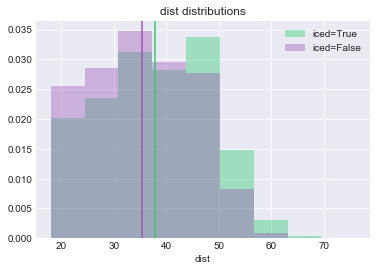

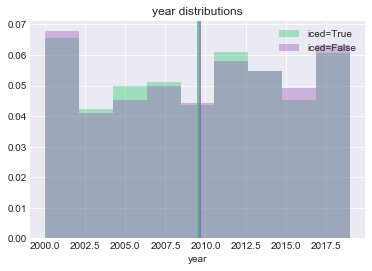

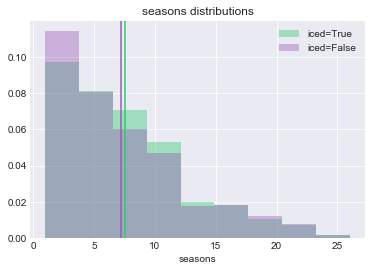

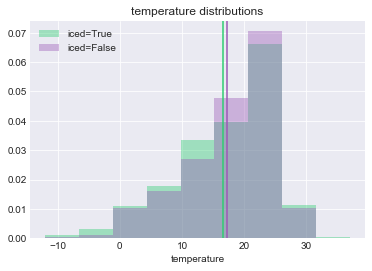

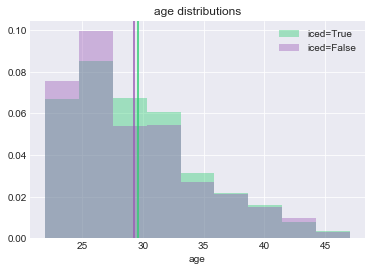

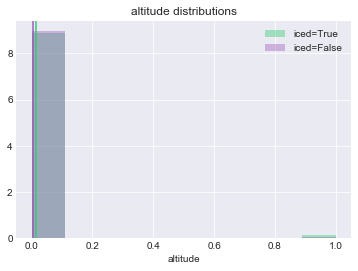

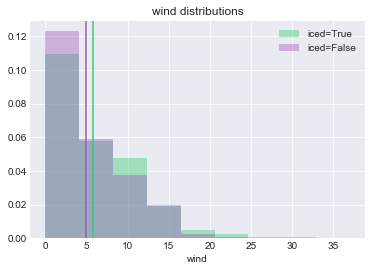

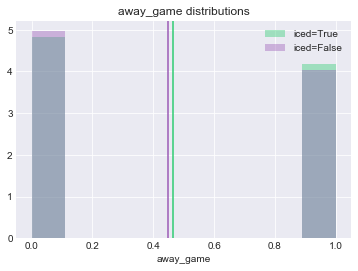

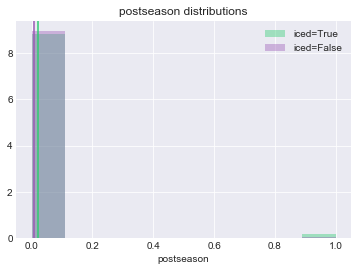

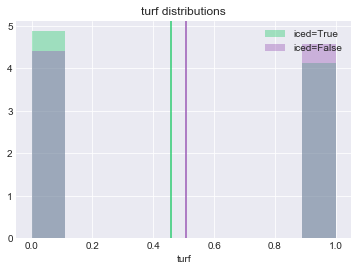

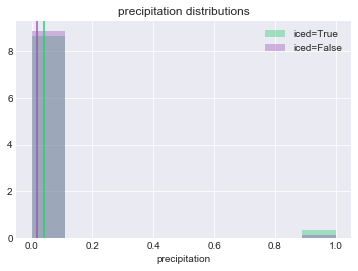

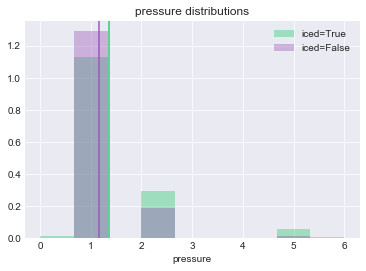

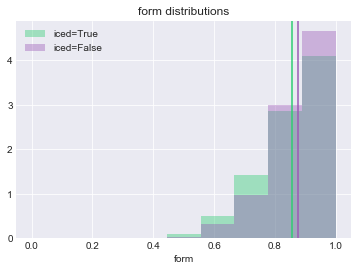

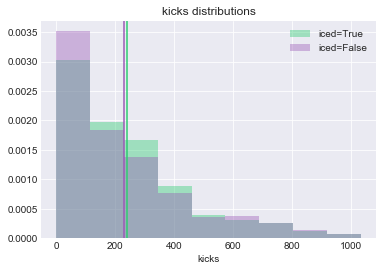

In [27]:
from util.matching import covariate_dists
covariate_dists(df_matched.drop('good', axis=1), on=on, kde=False, hist=True, n_bins=10)

The distributions look quite well balanced. We try plot the L1 frontier.

In [48]:
# from util.matching import L_frontier
# frontier = L_frontier(df_coarse.drop(['good', 'turf', 'away_game'], axis=1), on)

[(0, 3), (0, 3), (0, 3), (0, 3), (0, 2), (0, 2), (0, 1), (0, 1), (0, 1), (0, 6), (0, 2), (0, 2)]
[4, 4, 4, 4, 3, 3, 2, 2, 2, 7, 3, 3]
L1: 133.5


TypeError: list indices must be integers or slices, not tuple

### Mahalanobis Matching

* Mahanalobis distance with radius matching
* The radius is chosen such that the covariate distributions are largely indistinguishable.
* The frontier is the aggregate Mahalanobis distance for all minimum distances between group individuals below a threshold.
* How wide can we make our radius (reduce variance) before we lose covariate distribution similarity (increase bias)?

Mahalanobis distance assumes normal covariate distributions, so we must transform our bernoulli and poisson random variables.

In [ ]:
# TODO: transform

In [15]:
from util.matching import mahalanobis_frontier, match_by_distance

In [16]:
df[on] = df[on].astype(bool)
df_mf = mahalanobis_frontier(df.drop('good', axis=1), on)
df_mf

106 distances to check.
Checked 1/106 distances
Checked 11/106 distances
Checked 21/106 distances
Checked 31/106 distances
Checked 41/106 distances
Checked 51/106 distances
Checked 61/106 distances
Checked 71/106 distances
Checked 81/106 distances
Checked 91/106 distances
Checked 101/106 distances


,pruned controls,pruned treatments,AMD,radius
0,0,0,2.598655,11.3
1,0,0,2.598655,11.0
2,0,0,2.598655,10.9
3,0,0,2.598655,10.8
4,0,0,2.598655,10.7
...,...,...,...,...
101,2404,89,0.845619,1.0
102,2411,95,0.710147,0.9
103,2412,96,0.655839,0.8
104,2413,97,0.588793,0.7


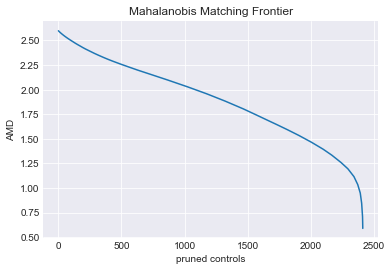

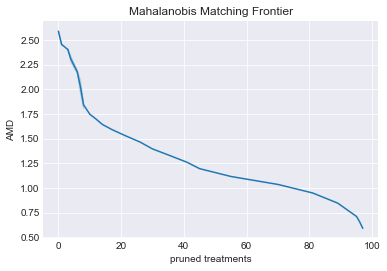

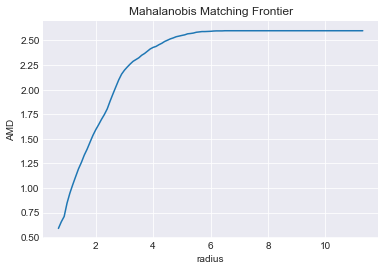

In [17]:
sns.lineplot(x='pruned controls', y='AMD', data=df_mf)
plt.title('Mahalanobis Matching Frontier')
plt.show()
plt.title('Mahalanobis Matching Frontier')
sns.lineplot(x='pruned treatments', y='AMD', data=df_mf)
plt.show()
plt.title('Mahalanobis Matching Frontier')
sns.lineplot(x='radius', y='AMD', data=df_mf)


* AMD vs Pruned controls is near linear, so that doesnt help us.
* AMD vs Pruned treatments drops fairly quick until about 10-15 are pruned (at ~1.7 AMD)
* This equates to a radius of about 2

In [30]:
df_matched = match_by_distance(df, on, 'good', 'mahalanobis', 2)

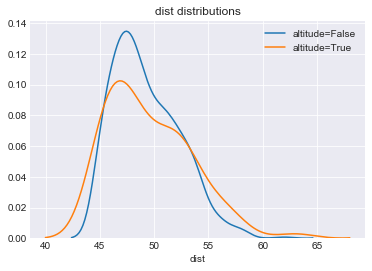

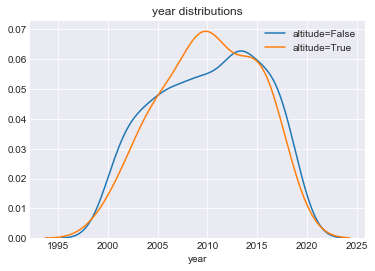

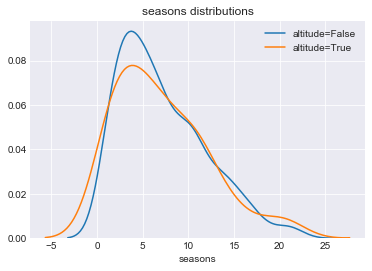

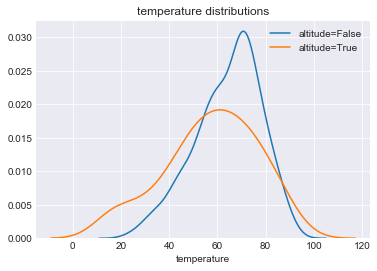

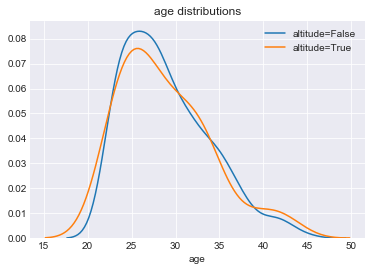

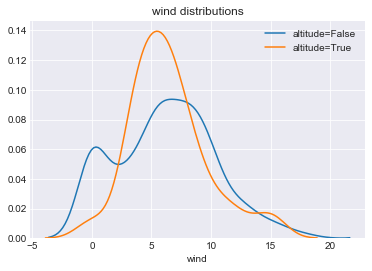

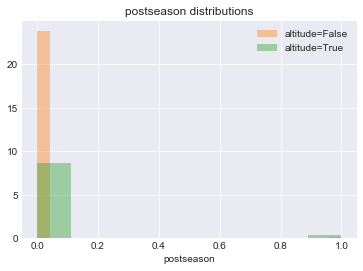

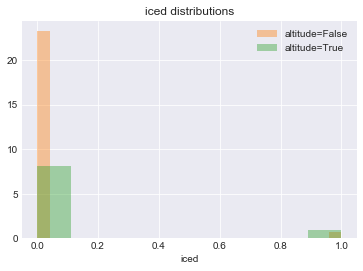

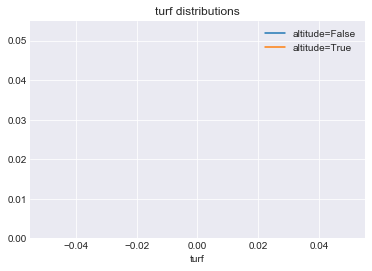

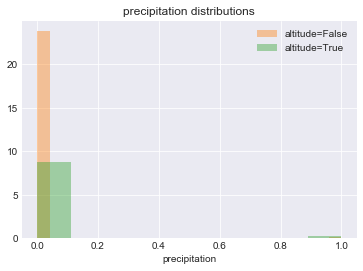

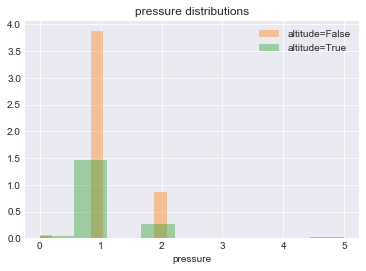

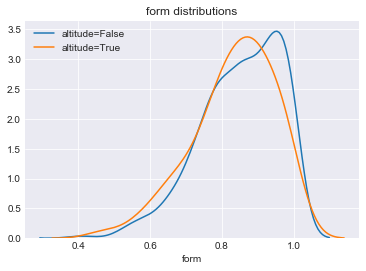

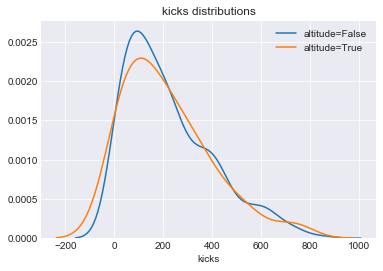

In [31]:
from util.matching import covariate_dists
covariate_dists(df_matched.drop('good', axis=1), on=on, , kde=False, hist=True, n_bins=10)

## Model

We work within a Bayesian framework, setting a prior distribution on the true population proportion and update the prior after our observations. The Beta-Binomial conjugacy makes this process relatively pain-free. Our prior mean is the sample population proportion (all kicks).

### NOTE: Stratify on distance!

In [151]:
# dist_level = (df_matched['dist']>=40) & (df_matched['dist']<50)
dist_level = (df_matched['dist']>=45)
print(len(df_matched.loc[(df_matched[on]==1) & dist_level, :]), on, len(df_matched.loc[(df_matched[on]==0) & dist_level, :]), f'not {on}.')

398 iced 1130 not iced.


In [152]:
from scipy.stats import beta
p_hat = df_matched.loc[dist_level, 'good'].mean()
alpha_ = 10
beta_ = int(round(alpha_*(1-p_hat)/p_hat))
print(f'alpha: {alpha_}, beta: {beta_}')

alpha: 10, beta: 4


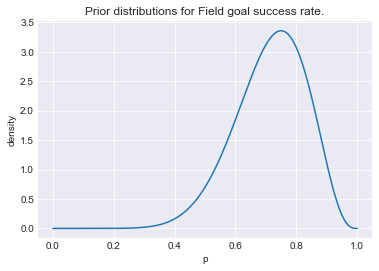

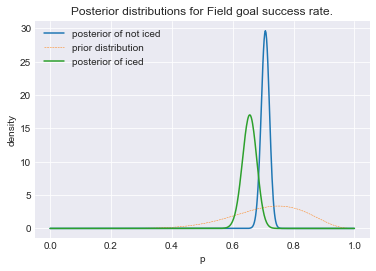

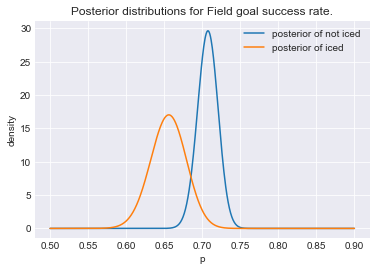

In [153]:
from util.bayes import BetaBinomial

control = BetaBinomial(alpha_, beta_, f'not {on}')
treatment = BetaBinomial(alpha_, beta_, on)
control.plot_prior(show=True)
plt.cla()

control.observe(df_matched.loc[(df_matched[on]==0) & dist_level, 'good'])
treatment.observe(df_matched.loc[(df_matched[on]==1) & dist_level, 'good'])

control.plot_posterior(prior=False)
treatment.plot_posterior(show=True, prior=True)

# zoom in
x = np.linspace(0.5,0.9,500)
control.plot_posterior(x, prior=False, show=False)
treatment.plot_posterior(x, prior=False, show=True)

samples = 20000
samples_posterior_c = control.sample(samples)
samples_posterior_t = treatment.sample(samples)

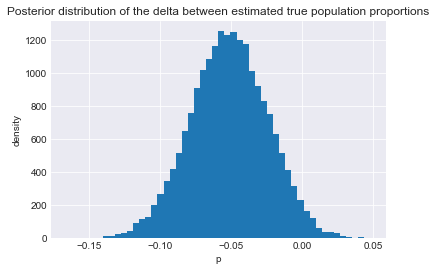

2% likely that iced has a greater true population proportion of converted field goals.
-0.05 is the median difference, with 50% credible interval of (0.0,-0.1).


In [154]:
posterior_diff = samples_posterior_t - samples_posterior_c

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions')
plt.show()
gt = int((samples_posterior_t>samples_posterior_c).mean()*100)
print(f'{gt}% likely that {on} has a greater true population proportion of converted field goals.')

from scipy.stats import bayes_mvs
alpha = 0.5
center, _, _ = bayes_mvs(posterior_diff, alpha=alpha)
print(f'{round(center.statistic,2)} is the median difference, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

We are sometimes interested in relative increase. For instance, the difference between 0.6 and 0.7 is relatively larger than the difference between 0.7 and 0.8.
We calculate relative increase of our treatment over control using our posterior distributions.

0 % likely relative lift is greater than 5%.
-0.07 is the median relative lift, with 50% credible interval of (0.0,-0.15).


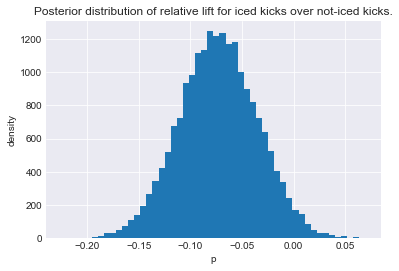

In [155]:
posterior_relative = (samples_posterior_t-samples_posterior_c)/samples_posterior_c
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title(f'Posterior distribution of relative lift for {on} kicks over not-{on} kicks.')
print(int((posterior_relative>0.05).mean()*100), r'% likely relative lift is greater than 5%.')

alpha = 0.5
center, _, _ = bayes_mvs(posterior_relative, alpha=alpha)
print(f'{round(center.statistic,2)} is the median relative lift, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')